A notebook for viewing random acta column event sequences, with some fine procedural details about 2019's preliminary vote count (TREP).

In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML, Image, display
from os.path import exists
import requests
import time

In [2]:
# if you want to have local imgs, you'll find them here: https://archive.org/download/bolivia_eg2019_result/
LOCAL_IMG = False # true = uses local imgs, false = uses archive.org instead. if using local, expected structure is 'data/[computo|trep|proveidos]/[NUMERO_MESA].jpg'. so: 'data/computo/10001.jpg', for example.
RNG = np.random.default_rng(seed=int(time.time())) # for selecting random acta columns below.

In [3]:
# three different possible sources for the trep dataset
#trep = pd.read_excel('https://archive.org/download/bolivia_eg2019_result/TREP/2019-bolivia-trep-actalog.xlsx', index_col='evt_id') # same, but on archive.org.
trep = pd.read_parquet('data/2019-bolivia-trep-actalog.pq') # much faster than xl. index is already set to 'evt_id'

# drop non-presidential columns.
trep = trep.drop(index=trep[trep.ElecActa != 'Presidente y Vicepresidente'].index)

In [4]:
# note: col_id = acta column identifier. it's a key based on unique combo of: (NumMesa = polling station id, ElecActa = election type.)
# note: the rows (=events) are sorted chronologically, so last really is (chronologically) last.
final_events = trep.groupby('col_id').evt_type_fullname.last() # get final event type for each acta column.

# some lists of useful values.
event_types = trep.evt_type_fullname.unique()
basic_cols = ['NumMesa', 'ElecActa', 'EstadoActa', 'evt_type_fullname']
party_cols = trep.loc[:,'CC':'PAN-BOL'].columns.to_list()
verif_cols = party_cols + list(trep.loc[:,'Validos en Acta':'Nulos'].columns) # all the numeric vote cols.

# convenience function to get a random acta column's events.
def get_rand_sequence(final_evt=None):
    rand_col_id_pool = []
    if final_evt is None: # pick from all columns
        rand_col_id_pool = trep.col_id.unique()
    elif isinstance(final_evt, str): # pick from cols that ended in final_evt
        rand_col_id_pool = final_events[final_events == final_evt].index # index is col_id value.
    elif isinstance(final_evt, list): # pick from cols that ended in any of final_evt events
        rand_col_id_pool = final_events[final_events.isin(final_evt)].index # index is col_id value.
        
    #print(f"Possible actas to select: {len(rand_col_id_pool)}")
        
    if len(rand_col_id_pool) == 0:
        raise ValueError(f'No matching columns that end in event(s): {final_evt}')
    
    rand_col_id = RNG.choice(rand_col_id_pool, 1)[0]
    return trep[trep.col_id == rand_col_id]

###########
# thing i didn't know: it rejected verifications where 'válidos en actas' > inscritos, even when actual counted_votes < inscritos.
# example: mesa 72900, president.
###########

# display acta column sequence.
cols_to_show = basic_cols + ['evt_time', 'Inscritos'] + verif_cols + ['Emitidos Reales']
def show_sequence(seq):
    # style acta column sequence vote totals.
    # green = matching total, red = non-matching total, more or less.
    def highlight_totals(col_seq, final_state):
        if final_state == 'Registrada':
            return [''] * len(col_seq)
        if final_state == 'Esperando aprobación':
            return [f"color:{'red' if col_seq.nunique() > 1 else 'green'}"] * len(col_seq) # could improve a bit, i guess, for multi-transmit edge cases.
        return np.where(col_seq == col_seq.iloc[-1], "color:green", "color:red")
    
    table = seq[cols_to_show].style \
        .apply(lambda x: highlight_totals(x, seq.EstadoActa.iloc[-1]), subset=verif_cols) \
        .apply(lambda x: np.where(x > seq.Inscritos, "color:red", ""), subset=['Validos en Acta', 'Emitidos Reales']) # trep checks for too many votes when comparing transcriptions.
    
    imgs = []
    if LOCAL_IMG:
        img_uri = f"data/trep/{seq.NumMesa.iloc[0]}.jpg"
        if exists(img_uri):
            imgs.append(Image(img_uri))
        
        imgs.append(Image(img_uri.replace('trep', 'computo')))
        
        prov_uri = img_uri.replace('trep', 'proveidos')
        if exists(prov_uri):
            imgs.append(Image(prov_uri))
    else:
        img_uri = f'https://archive.org/download/bolivia_eg2019_result/TREP/2019-bolivia-trep-actas.zip/{seq.NumMesa.iloc[0]}.jpg'
        r = requests.get(img_uri, allow_redirects=True)
        if len(r.content) > 0:
            imgs.append(Image(r.content))
        
        imgs.append(Image(img_uri.replace('TREP', 'COMPUTO').replace('trep', 'computo')))
        
        prov_uri = f'https://archive.org/download/bolivia_eg2019_result/COMPUTO/2019-bolivia-computo-proveidos.zip/proveidos%2F{seq.NumMesa.iloc[0]}.jpg'
        r = requests.get(prov_uri, allow_redirects=True)
        if len(r.content) > 0:
            imgs.append(Image(r.content))
                    
    display(table, *imgs)

<h2><center>Random Acta Sequence Viewer</center></h2>

Reload the cell below to see a new random acta column's event sequence.

,NumMesa,ElecActa,EstadoActa,evt_type_fullname,evt_time,Inscritos,CC,FPV,MTS,UCS,MAS,21F,PDC,MNR,PAN-BOL,Validos en Acta,Blancos,Nulos,Emitidos Reales
evt_id,,,,,,,,,,,,,,,,,,,
123394,77014,Presidente y Vicepresidente,Registrada,Transmission,2019-10-20 18:47:51,218,25,2,1,0,115,17,17,0,1,178,5,6,189
123395,77014,Presidente y Vicepresidente,Esperando aprobación,Failed Verification,2019-10-20 19:45:29,218,25,2,1,115,115,17,17,0,1,178,5,6,304


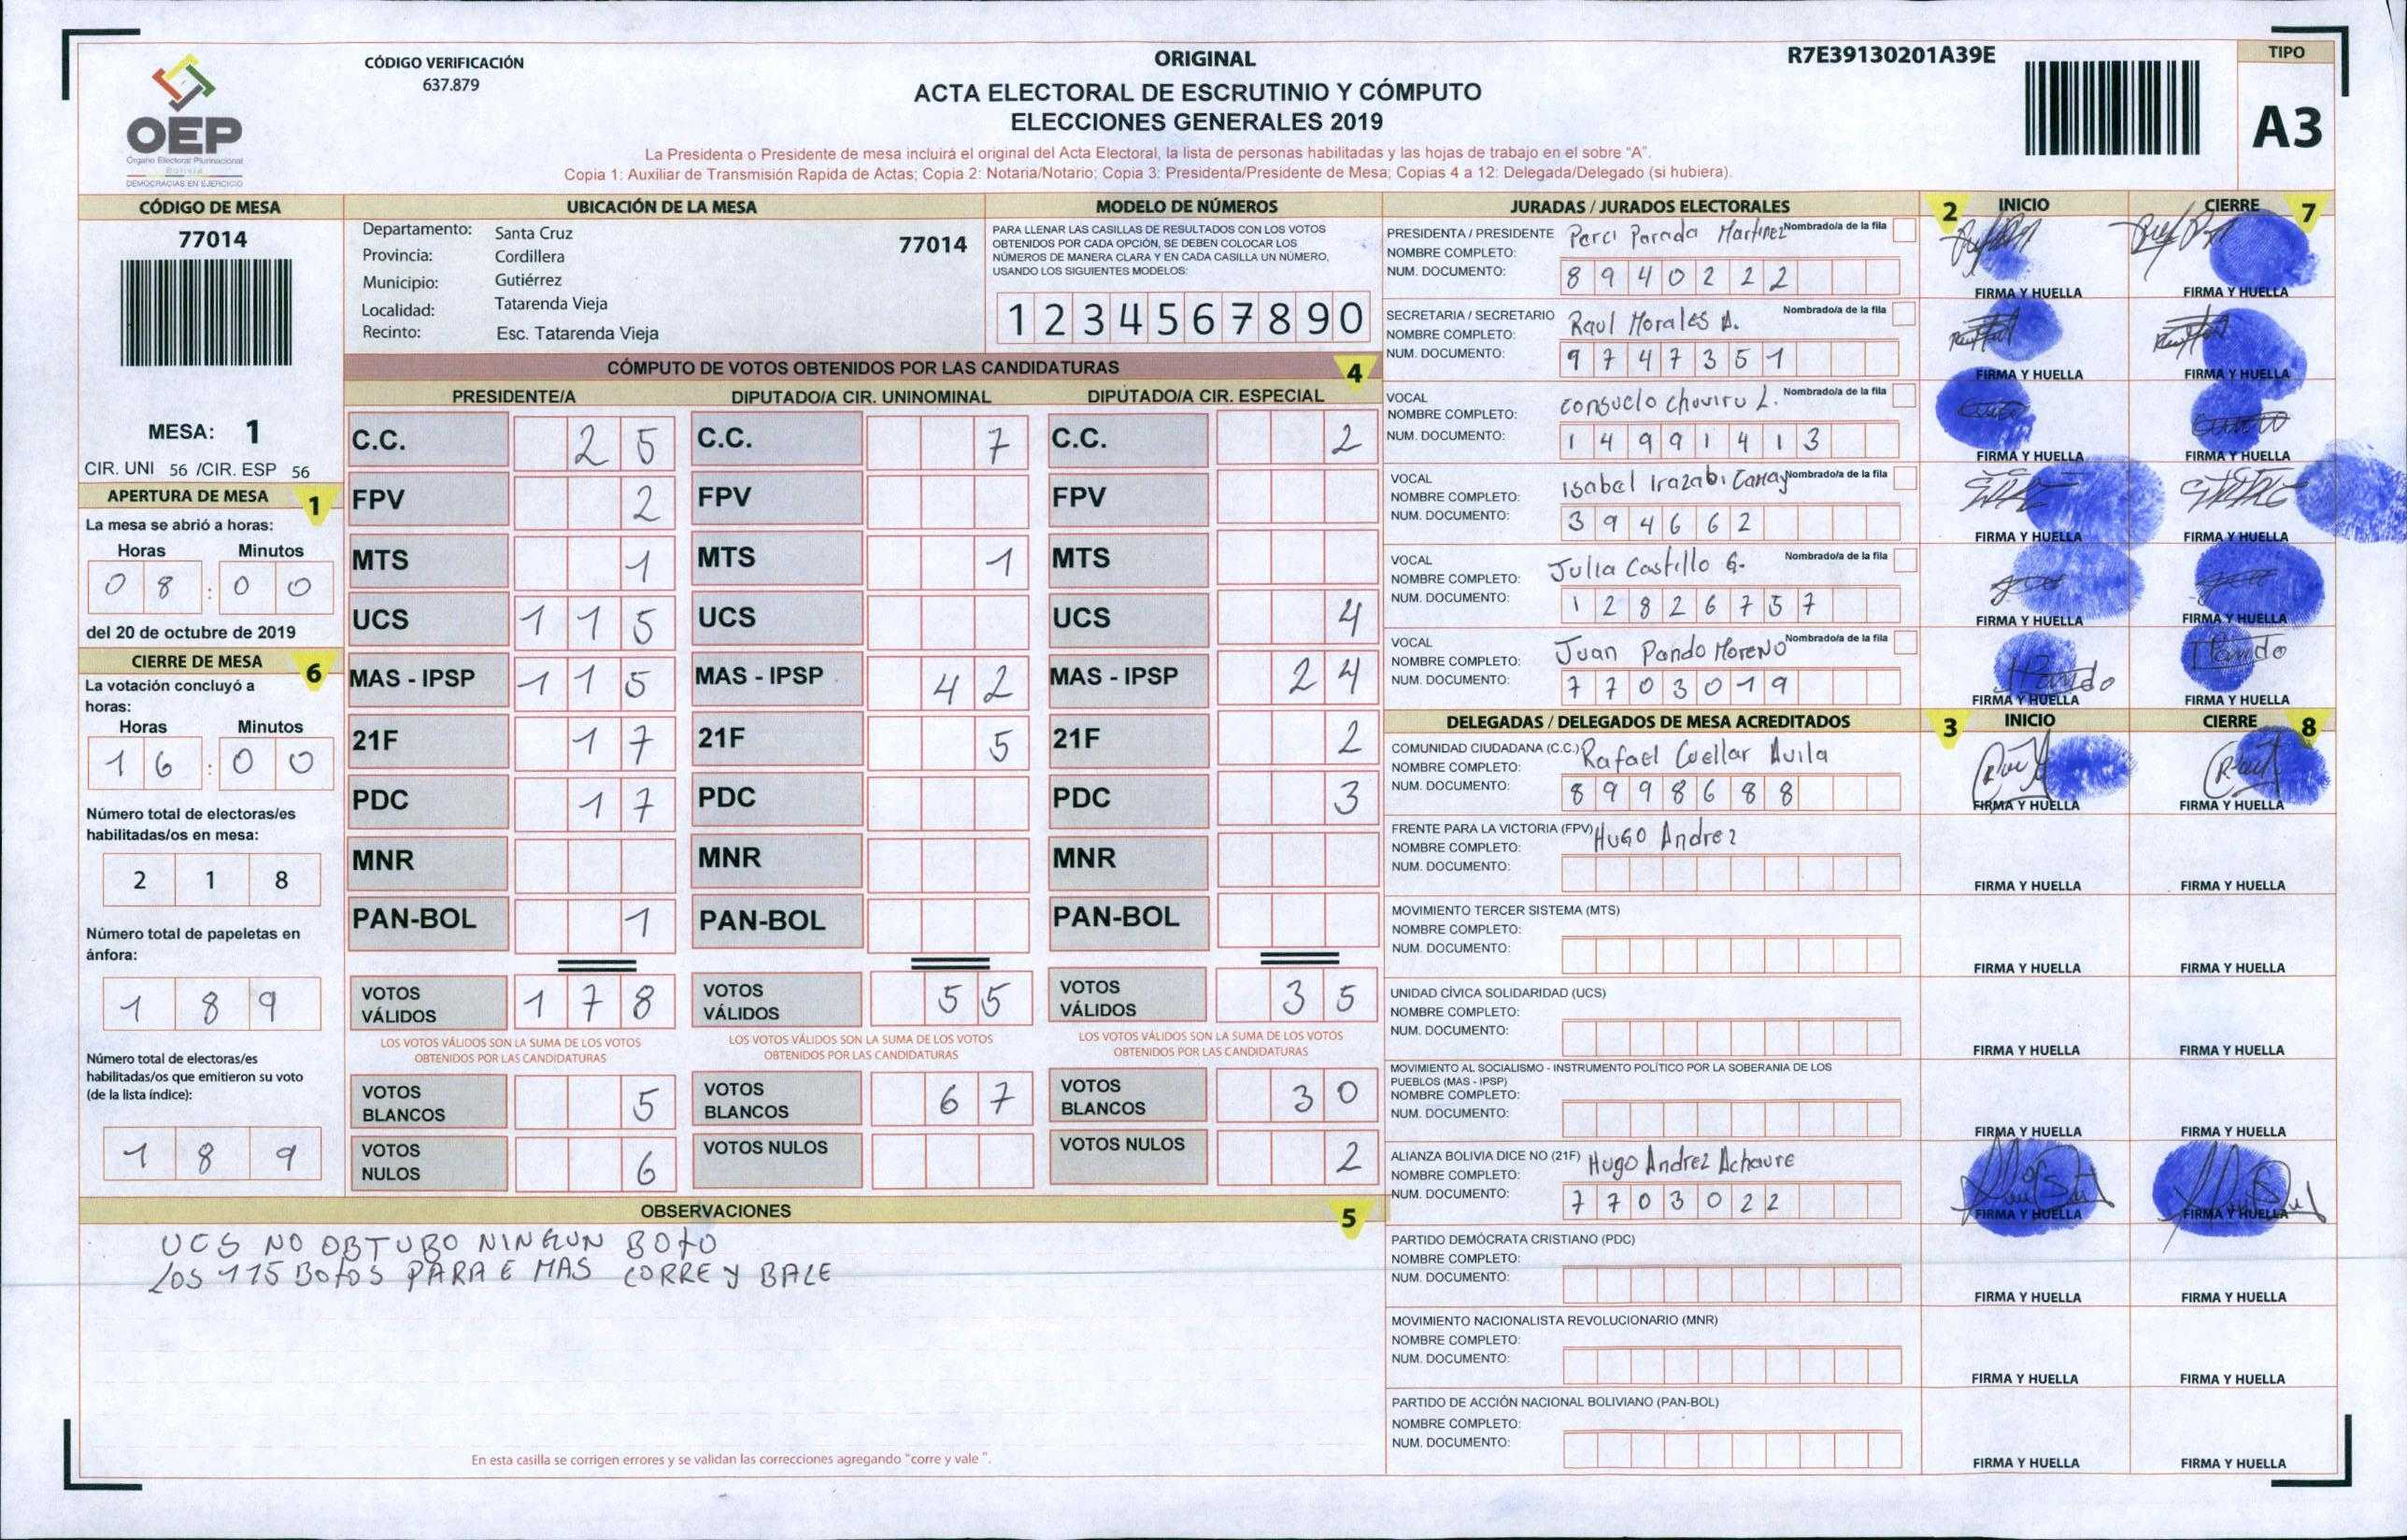

In [17]:
# events: 'Verification', 'Transmission', 'Failed Verification', 'Approval'. i chose ['Failed Verification', 'Approval'] to show the two are very similar.
show_sequence(get_rand_sequence(final_evt='Failed Verification')) # can also use a list: ['Failed Verification', 'Approval']

So, a couple basic points about the images:
- The first image (if it exists and I have it) is the TREP image, second is the Cómputo scan from the Departmental Electoral Tribunal, and third (if it exists) is the Cómputo proveído from the Departmental Electoral Tribunal. (A proveído is a note written on the reverse side of the acta to explain an interpretative decision that electoral officials made.)
- Unfortunately, I don't have TREP images for actas from Santa Cruz (NumMesa starts with '7') whose presidential column went unverified.

A few details to keep in mind while reviewing the event sequences:
- The transmission operator can send a transcription for an acta column as many times as they want, so long as there hasn't been a verification attempt on it.
- The transmission operator can see the physical acta, but the verification operator can only see the (sometimes illegible) image the transmission operator sent.
- The signature next to a correction is almost always the table president's signature (top-most electoral juror), which you can confirm by comparing the two signatures.
- Verification operators -- who are sitting in front of a laptop in a crowded building in La Paz, rapidly transcribing acta images -- are under greater time-pressure than transmission operators, and so tend to be less observant and more prone to making mistakes and overlooking fine details.

Some of the many reasons for verification failures:
- Transcription errors. For example:
    - Misread a vote total.
    - Fat-fingered one of the digits in the vote total.
    - Shifted the vote totals one position. (Party #4 is in Party #5's slot, for example.)
    - Transcribed the wrong election.
    - Etc, etc.
- Carbon copies -- which can be distinguished by their color and the word 'COPIA' at the top of the document -- are more likely to produce verification failures because the markings on them can be faint and difficult to read for the verification operator. In nearly all cases of TREP photos of carbon copies, I think the TREP transmission operator photographed their personal copy ('Copia 1: Auxiliar de Transmisión Rápida de Actas'). It's worth noting these copies were likely detached as soon as vote totals were filled out, which explains why certain end-of-day details, like juror and delegate signatures and fingerprints, are often missing on copies. This is a <i>generalized</i> phenomenon, though. It's also present, for example, in Potosí, the most anti-MAS capital in all of Bolivia, whose TREP photos are nearly all of carbon copies that show <a href="https://docs.google.com/spreadsheets/d/1u6pPfFLsKAiAbSio4r8_Dzgl1JxZ9YEH/edit?usp=sharing&ouid=102828709542898650242&rtpof=true&sd=true">similar patterns</a>.
- Inconsistent treatment of corrections. The acta has a correction written in the 'Observaciones' section and one operator took this correction into account, whereas the other didn't, so the two transcriptions didn't match and the verification failed. (Note: This is the real explanation for the OAS's Hallazgo #4.)
- Illegible acta image. In moderate cases, this will induce errors from the verification operator, but in severe cases, the operator will throw their hands up and submit a no-vote transcription (=all zeros).
- Too many votes. Specifically: ('Válidos en Acta' > 'Inscritos') OR ('Emitidos Reales' > 'Inscritos'), so the TREP application automatically rejected the verification attempt. The reason for nearly all of these cases is given in the next section's explanation of slip-ups while copying vote totals from the worksheets to the official acta.
- Acta shown in the TREP image belongs to the wrong table.
- The acta has complex corrections which need to be reviewed in the official count (see: NEOTEC #1 10/28/2019, p3).
- In a few cases, the transmission operator didn't fill out any vote totals in their transcription (so, all zeros).
- One of the operators didn't bother to fill in the 'Válidos en Acta' subtotal (so it's given as zero).
- The 'Válidos en Acta' subtotal in the transmission operator's transcription was calculated independently. In other words, the number they use does not appear anywhere on the acta, so the verification operator, who is simply transcribing the numbers visible in the acta image, is extremely unlikely to reproduce the value.

Some errors jurors make while filling out actas:
- Miscalculated 'Válidos en Acta'. The juror failed to realize that votos_validos = sum(all_parties), not sum(all_parties) + blanks + nulls. Often jurors will add a correction of this error in the 'Observaciones' section, but if not, electoral officials at the Departmental Electoral Tribunal can correct it - see: <a href="https://www.lexivox.org/norms/BO-L-N26.html">Ley del Régimen Electoral (026), Art 176, d</a>.
- To fill out an acta, jurors first record the vote totals on a worksheet, then copy those totals to the official acta. However, they sometimes copy the same total twice by mistake. In these cases, you'll see two parties in adjacent boxes credited with the exact same number of votes, typically a number that makes sense for one party but not for the other. Because Bolivian elections have such high turnout (around 90%), when a vote total for a major party (or, in some instances, a subtotal) is copied twice by mistake, this will often result in there being more votes than registered voters on the acta (although this is always corrected, either by the jurors themselves in the 'Observaciones' section of the acta or, if necessary, by an electoral official at the Departmental Electoral Tribunal after they've reviewed the worksheet - see: <a href="https://www.lexivox.org/norms/BO-L-N26.html">Ley del Régimen Electoral (026), Art 177, II</a>).
- While filling out the acta, sometimes jurors mistakenly copy the vote totals for a congressional election into the space for the presidential election or vice versa. It's usually easy to tell when they've done this, since the presidential election will have far fewer valid votes than the congressional election, the opposite of what one would expect.
- Mistreatment of unused ballots. Jurors shouldn't count uncast ballots, but sometimes they record them as blanks or, less commonly, as nulls.
- Mistake with the bottom left totals. These fields don't affect any vote counts and are only there as an consistency check for jurors. The first total is 'ballots in ballot box' and the second is, in effect, 'signatures on the voter roll' (both should match). Sometimes jurors give the table's total number of registered voters by mistake, though.
- In the 'Delegados de Mesa Acreditados' section, party delegates sometimes fill out the first blank slot, rather than their party's designated slot.
- Jurors sometimes give the table's closing time in 12-hour, rather than 24-hour, format.
- Jurors sometimes put their names in the boxes for their ID number and their ID number on the line for their names.

<center><h3>Why Weren't More Actas Approved?</h3></center><br>
So, I hope you've reviewed some acta columns and are convinced this is all quite banal. Still, you must be wondering: If the mistakes on many unapproved actas are so trivial, why weren't they resolved in the approval process? Well, as far as I can tell, the TSE was short-handed (<a href="https://scm.oas.org/pdfs/2020/CP43202SINFORMEBOLIVIAMOAS.pdf">EOM/OAS Report 2019/2020</a>, p19, 'recursos tecnológicos') and reviewers fell behind schedule due to the interruption of the count on Election Night. Then, at 18:30 the following day, the TREP website updated for the first time in a day and showed the MAS with a 10.15-point lead. The MAS's political opponents reacted by denouncing the results (<a href="https://twitter.com/OEA_oficial/status/1186455002337959937">OAS</a> @ 21:31) and burning down the Departmental Electoral Tribunals where the official count was being conducted (<a href="https://twitter.com/Mojris/status/1186450855400235010">turba sucrense</a> @ 21:15 at the latest). So, at 21:44, the TSE appears to have simply abandoned the TREP review process.

<center><h3>Why are Actas that Ended on a Failed Verification Unusually Favorable to the MAS?</h3></center>

Well, it requires a bit of explanation. First, I'll establish the start time and end time from the last day of the review process (*October 21st*):

In [6]:
# establishing when approval process started and ended on oct21.
# for simplicitly, i'm going to count the vote totals from the column's latest trep event. i could use cómputo totals, but not a massive difference.
oct21_aprobs = trep[(trep.evt_type == 'aprob') & (trep.evt_time > '2019-10-21') & (trep.evt_time < '2019-10-22')]
first_oct21_aprob, last_oct21_aprob = oct21_aprobs.evt_time.iloc[0], oct21_aprobs.evt_time.iloc[-1]
{'oct21_review_start': first_oct21_aprob, 'oct21_review_end': last_oct21_aprob}

{'oct21_review_start': Timestamp('2019-10-21 15:01:52'),
 'oct21_review_end': Timestamp('2019-10-21 21:43:50')}

When the review process restarted at 15:02, the MAS's lead on counted actas and review-eligible actas was relatively similar:

In [7]:
# convenience functions for getting vote shares and acta counts and displaying them. used below.
def sum_df(df): # convenience function.
    series_sums = df[party_cols].sum()
    series_out = pd.Series(series_sums / series_sums[party_cols].sum())
    series_out['actas'] = len(df)
    return series_out

def display_cmp(*dfs):
    cmp_df = pd.concat(dfs, axis=1).transpose()
    display(cmp_df.style.format({x: '{:.2%}'.format for x in party_cols}).format({'actas': '{:,.0f}'.format}))

In [8]:
counted = pd.Series(sum_df(trep[(trep.EstadoActa == 'Verificada') & (trep.evt_time < first_oct21_aprob)]), name='counted_when_reviews_start_oct21')

# get the columns stuck in the review process when approvals start on oct21
final_evts_before_oct21_aprob = trep[trep.evt_time < first_oct21_aprob].groupby('col_id').evt_type_fullname.last()
oct21_marked_for_review = trep[
    trep.col_id.isin(final_evts_before_oct21_aprob[final_evts_before_oct21_aprob == 'Failed Verification'].index)
].groupby('col_id').last() # using each col's last event's vote totals (in whole trep) just for convenience, not a huge difference if i use other methods.
to_be_reviewed = pd.Series(sum_df(oct21_marked_for_review), name='review-eligible_oct21')

In [9]:
display_cmp(counted, to_be_reviewed)

,CC,FPV,MTS,UCS,MAS,21F,PDC,MNR,PAN-BOL,actas
counted_when_reviews_start_oct21,36.65%,0.39%,1.25%,0.42%,46.95%,4.21%,8.78%,0.69%,0.65%,"32,536"
review-eligible_oct21,35.01%,0.47%,1.65%,1.18%,45.58%,5.56%,8.48%,1.01%,1.06%,"1,581"


Then, from 15:02 to 21:44, users processed review-eligible columns. By vote share, here's what was eligible for review and what *actually* got reviewed:

In [10]:
reviewed_oct21 = pd.Series(sum_df(oct21_aprobs), name='reviewed_oct21')
display_cmp(to_be_reviewed, reviewed_oct21)

,CC,FPV,MTS,UCS,MAS,21F,PDC,MNR,PAN-BOL,actas
review-eligible_oct21,35.01%,0.47%,1.65%,1.18%,45.58%,5.56%,8.48%,1.01%,1.06%,"1,581"
reviewed_oct21,42.03%,0.32%,1.75%,0.44%,40.96%,4.08%,9.15%,0.66%,0.62%,504


Somehow, CC received more votes than the MAS on the columns that were reviewed, despite a 10-point disadvantage on review-eligible actas.

It has a simple explanation, though. It's due to a selection bias in the review process. The columns that got chosen for review were mostly from large cities where the opposition did well (and the columns that weren't chosen tended to be from peripheral areas where the MAS did well). This can be seen in a simple municipal breakdown:

In [11]:
muni_counts = oct21_aprobs.Muni.value_counts()
muni_counts

Santa Cruz de La Sierra     162
El Alto                     102
Cochabamba                   62
Nuestra Señora de La Paz     41
Tarija                       19
Bermejo                      14
Yacuiba                      13
Sucre                        12
Villa Montes                  6
Achacachi                     5
Murcia                        4
C.A. Buenos Aires             3
Mocomoco                      3
Colquencha                    3
Huarina                       3
Sao Paulo                     3
Uriondo (Concepción)          3
El Puente                     3
Caraparí                      2
Ixiamas                       2
Mecapaca                      2
Sicasica                      2
Calamarca                     2
Patacamaya                    2
Palca                         2
Lomas de Zamora               2
Entre Ríos                    2
Shinahota                     1
Warnes                        1
Caquiaviri                    1
Ayata                         1
Villa An

Specifically, departamental capitals and El Alto -- which constitute 50.4% of all the mesas in the election -- make up 79.2% of the reviewed columns.

In [12]:
capitals_plus_elalto = ['Sucre', 'Nuestra Señora de La Paz', 'El Alto', 'Cochabamba', 'Oruro', 'Potosí', 'Tarija', 'Santa Cruz de La Sierra', 'Trinidad', 'Cobija']
major_city_counts = muni_counts[muni_counts.index.isin(capitals_plus_elalto)]
f"{(major_city_counts.sum() / muni_counts.sum() * 100).round(1)}%"

'79.2%'

Columns from those major cities are so picked-over that they're only 30.6% of the review-eligible columns at the end of the count.

In [13]:
muni_counts2 = trep[trep.col_id.isin(final_events[final_events == 'Failed Verification'].index)].drop_duplicates(subset='col_id').Muni.value_counts()
major_city_counts2 = muni_counts2[muni_counts2.index.isin(capitals_plus_elalto)]
f"{(major_city_counts2.sum() / muni_counts2.sum() * 100).round(1)}%"

'30.6%'

The reason for this is that reviewers could pick which columns to review, and on October 21st they focused on columns from major cities. The logs show five reviewers that day:

In [14]:
aprob_users = oct21_aprobs.AprobadorUser.value_counts()
aprob_users # val = number of presidential columns approved.

USUARIO_4449    131
USUARIO_5238    127
USUARIO_4409    123
USUARIO_3569     70
USUARIO_5842     53
Name: AprobadorUser, dtype: int64

If you do a simple municipal breakdown on the individual users, it's clear that most focused on specific (urban) areas.

In [15]:
last_index = len(aprob_users) - 1
for i, user in enumerate(aprob_users.index):
    aprob_series = pd.Series(oct21_aprobs[oct21_aprobs.AprobadorUser == user].Muni.value_counts(), name=user)
    display(aprob_series)
    if i < last_index:
        display(HTML('<br>'))

Santa Cruz de La Sierra     88
Cochabamba                  18
Sucre                        6
Nuestra Señora de La Paz     5
Murcia                       4
Sao Paulo                    3
C.A. Buenos Aires            3
Lomas de Zamora              2
El Alto                      1
Warnes                       1
Name: USUARIO_4449, dtype: int64

El Alto                     100
Achacachi                     3
Nuestra Señora de La Paz      3
Palca                         2
Ixiamas                       2
Huarina                       2
Mecapaca                      2
Mocomoco                      1
Ayata                         1
Santiago de Huata             1
Caquiaviri                    1
Comanche                      1
Patacamaya                    1
Coripata                      1
Coroico                       1
Oruro                         1
Tapacarí                      1
Sucre                         1
Puerto Mayor de Carabuco      1
Puerto Mayor de Guaqui        1
Name: USUARIO_5238, dtype: int64

Nuestra Señora de La Paz    32
Tarija                      19
Bermejo                     14
Yacuiba                     13
Villa Montes                 6
Sucre                        5
Uriondo (Concepción)         3
El Puente                    3
Colquencha                   3
Caraparí                     2
Achacachi                    2
Calamarca                    2
Entre Ríos                   2
Sicasica                     2
Mocomoco                     2
Palos Blancos                1
Villa Ancoraimes             1
Laja                         1
Sapahaqui                    1
Irupana                      1
Patacamaya                   1
El Alto                      1
San Pedro de Curahuara       1
Collana                      1
Huarina                      1
Incahuasi                    1
Achocalla                    1
Padcaya                      1
Name: USUARIO_4409, dtype: int64

Santa Cruz de La Sierra    70
Name: USUARIO_3569, dtype: int64

Cochabamba                  44
Santa Cruz de La Sierra      4
Tarata                       1
Shinahota                    1
Cocapata                     1
Villa Tunari                 1
Nuestra Señora de La Paz     1
Name: USUARIO_5842, dtype: int64

So, approval operators picked acta columns from major cities where the opposition did well. They were able to do this because approval operators, unlike verification operators, could <a href="https://youtu.be/sn7Zna00l7I?t=87">choose</a> which columns to review from a filterable list of eligible columns. The reviewers' preference for columns from urban anti-MAS areas caused the MAS's lead in the counted vote to fall from 10.3 points (at 15:02) to 10.12 points by the end of the review process (at 21:44). Also, this selection bias meant that the unselected actas tended to be from peripheral pro-MAS areas. When the TSE discontinued the review process at 21:44, lots of pro-MAS actas were left waiting for a review that would never come.

In [16]:
stuck_in_review_process = pd.Series(sum_df(trep[trep.col_id.isin(final_events[final_events == 'Failed Verification'].index)].drop_duplicates('col_id', keep='last')), name='stuck_in_review_process')
display_cmp(reviewed_oct21, stuck_in_review_process)

,CC,FPV,MTS,UCS,MAS,21F,PDC,MNR,PAN-BOL,actas
reviewed_oct21,42.03%,0.32%,1.75%,0.44%,40.96%,4.08%,9.15%,0.66%,0.62%,504
stuck_in_review_process,31.20%,0.54%,1.60%,1.61%,48.10%,6.35%,8.10%,1.20%,1.30%,"1,083"
